# Introduction to Spike Train Data

*The examples in this lesson were adapted from Chapter 3 of Nylen, E.L., and Wallisch, P.. (2017).* [Neural Data Science](https://www.sciencedirect.com/book/9780128040430/neural-data-science). *Academic Press. Code and explanatory text by Aaron J. Newman.*

In [1]:
# Import libraries we'll need
import matplotlib.pyplot as plt
import numpy as np

## Our first spike train

Imagine an experiment involving a neuron that was genetically engineered for [**optogenetics**](https://en.wikipedia.org/wiki/Optogenetics), meaning that it expresses genes sensitive to a specific wavelength of light (550 nm, which is green; to learn more about optogenetics, check out [this video by Prof. Carl Petersen](https://youtu.be/lqroI7sFVuk)). When light of that wavelength is directed at the neuron, it tends to fire. 

For this hypothetical experiment, we used an electrode to record action potentials from this optogenetically-engineered neuron to confirm that it tends to fire in response to 550 nm light. This was done across multiple trials. On each trial, recording was started and then the 550 nm light was turned on 4 ms later, for a duration of 10 ms. Each trial lasted a total of 20 ms. Data was sampled from the electrode every millisecond.

We can store the data from each trial in a list, `spike_train`. Each value represents an evenly-spaced point in time (e.g.,  every 1 ms), where `0` encodes time points at which no action potential was detected, and `1` represents times when action potentials occurred:

In [2]:
spike_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
len(spike_train)

21

The list has 21 values because the first value represents time point 0, when the recording started, and after this we recorded up to 20 ms.

### First spike latency

A characteristic feature of a neuron is the *first spike latency to stimulus* — how long after a stimulus the first spike occurs. Different neurons will have different average values of this. 

Since we know the light came on 5 ms after the start of each trial, we can define light onset time and duration as variables, and also defines that a spike is represented as a `1` in the data. Then, we can look for the first spike that occurred after the onset of the light. 

In [3]:
light_onset_time = 4
stimulus_duration = 10
spike_value = 1

To determine first spike latency relative to stimulus onset, we can search in the `spike_train` list starting with `light_onset_time` (using list slicing) and looking forward until we find the first spike (`spike_value`), using the `.index()` method which returns the first index in a list (or slice) matching the value given as the argument:

In [4]:
latency_to_first_spike = spike_train[light_onset_time:].index(spike_value) 
print('First spike latency to stimulus = ' + str(latency_to_first_spike))

First spike latency to stimulus = 5


### Find indexes of all spikes

If we want to find the indexes of all the spikes that occurred after stimulus onset, we need to use a `for` loop, because the `.index()` method only finds the first occurrence of a value in a list. 

Here we introduce a useful variant of the typical `for` loop, using the `enumerate()` function. While a regular `for` loop  simply loops through all values of a list (or other object), `enumerate()` does this while keeping track of the index of the current item within the loop. The `enumerate()` function returns two values every pass through the loop, which we assign to two variables, which here we call `i` and `x`. 

In [5]:
for i, x in enumerate(spike_train):
    print(i, x)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 1
10 0
11 1
12 0
13 1
14 0
15 0
16 0
17 1
18 0
19 0
20 0


In the output, the first column is the index (position) in the list, and the second column indicates whether a spike happened or not. 

We can use this in a nested `for`/`if` loop to step through each value in the list, and if it is a spike, append the index of that list position to a list called `spike_times`:

In [6]:
spike_times = []

for i, x in enumerate(spike_train):
    if x == spike_value:
        spike_times.append(i)

print(spike_times)

[9, 11, 13, 17]


### List Comprehension
Alternatively, we can do this more efficiently with [list comprehension](../3/for-loops.html#list-comprehension):

In [7]:
spike_times = [i for i, x in enumerate(spike_train) if x == spike_value]
print(spike_times)

[9, 11, 13, 17]


This is a slightly more complicated list comprehension than we've seen in the past. Take some time to break this down and understand it — there's a lot going on! Recall that list comprehension is used to create a `for` loop in a single line, and return a list. It's a useful and compact way to iterate over some set of items to get them into a list. In this list comprehension:
- The `enumerate()` function enumerates (counts) the items as it goes through a loop, so each time through the loop we have two variables being tracked. In this case, they are `x`, which is one value in `spike_train`, and `i`, the enumeration variable that stores the current position in the list (iteration through the loop). 
- To the end of this is added a conditional, `if x == spike_value`. This allows us to retrieve the index (timing) of only values when that represent spikes (recall we defined `spike_value` as `1`). The `for` statement followed by the `if` conditional is equivalent to nesting the `if` statement inside the `for` loop in the previous example. 
- The `i` right at the start of the list comprehension means that, if any value of `x` is a `1`, then the index of its list position, `i`, is added to the `spike_times` list.

For a detailed overview of list comprehension, check out [this DataCamp tutorial](https://www.datacamp.com/community/tutorials/python-list-comprehension).

---
## Visualizing a Spike Train: Raster Plots

Visualization is an effective way of making the data more interpretable. It is more intuitive for most people to see a timeline with spikes marked at particular time points, than to read a list of index values. Below we generate a **raster plot**, with time on the *x* axis, and the spikes as vertical lines. The *y* axis is shown as a continuous scale (the default in matplotlib), but of course the actual values can only be 0 or 1. 

Since `spike_times` contains the time points of our spikes, we can use the following code to draw an object-oriented plot in Matplotlib:

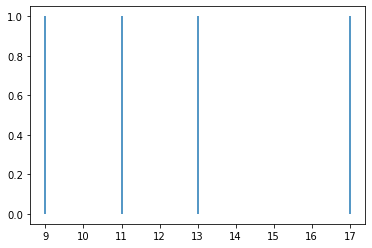

In [8]:
fig, ax = plt.subplots()
ax.vlines(spike_times, 0, 1)
plt.show()

You can see that we have a plot with vertical lines (in Matplotlib's default colour, blue) indicating the spike times. 

One thing to notice in the code for this plot is that it's kind of "hacking" Matplotlib functions to generate the plot. That is, we're not using the `plt.plot()` function or `ax.plot()` method. Instead, we use the `ax.vlines()` method (there is also a `plt.vlines()` function, if using the procedural approach to plotting). This function can be used for drawing a vertical line anywhere in a Matplotlib plot. It takes three arguments: the *x* value(s) at which we want to draw the vertical line(s), the *y* value for the start (bottom) of the line(s), and the *y* value for the end (top) of the line(s). 

### Formatting the plot
We can make the figure more informative though. Firstly, since the *x* axis is time, we should show the whole time period of the trial, from 0–20 ms, not just the range from the first to last spike. We can also label the *x* axis and add a title to facilitate interpretation:

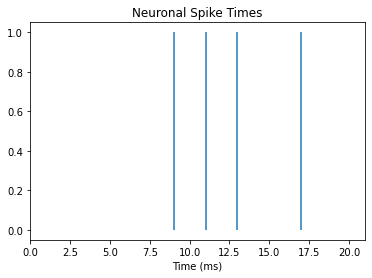

In [9]:
fig, ax = plt.subplots()
ax.vlines(spike_times, 0, 1)

# set x axis range and label
ax.set_xlim([0, len(spike_train)])
ax.set_xlabel('Time (ms)')

# add title to plot
ax.set_title('Neuronal Spike Times') 

plt.show()

### Add stimulus shading

Finally, we can show when the stimulus occurred, by shading the plot for the time between stimulus onset and offset. We use the `axvspan` function to add shading to the time period during which the green light was on, and we add the `alpha=` kwarg to adjust the transparency of the shading so we can see the blue lines (`alpha=1.0` would be opaque; `alpha=0.0` would be invisible).

Note the clever use of colour-coding: we use the `greenyellow` colour as this is closest to 550 nm. Thus rather than using an arbitrary or neutral shading colour like grey, the colour simultaneously encodes the time of the stimulus, and a key property of it.  This is effective communication!

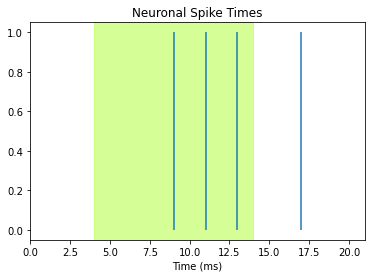

In [10]:
# define light offset time
light_offset_time = light_onset_time + stimulus_duration

fig, ax = plt.subplots()
ax.vlines(spike_times, 0, 1)

ax.set_xlim([0, len(spike_train)])
ax.set_xlabel('Time (ms)')

ax.set_title('Neuronal Spike Times') 

# add shading for stimulus duration)
ax.axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

plt.show()

## More Trials

One spike train is not representative of what that neuron would do every time it's stimulated. Neurons typically respond in  a *probabilistic* way to stimuli, meaning that presenting a stimulus that the neuron is tuned to will make the neuron more likely to fire, but it's firing at a specific time point is not guaranteed. As well, neurons can also fire spontaneously, irrespective of an experimental stimulus. For both these reasons, we need to determine what the typical, or average, response of a neuron is by measuring its activity over many trials. 

Below we have a set of 10 spike trains, representing 10 trials. These are stored as a list of lists, as we can tell from square brackets embedded in square brackets: 

In [11]:
ten_spike_trains = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], 
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], 
                    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0], 
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
                   ]

Although the nicely-formatted list of lists above is pretty easy to look at and see where spikes occur, a raster plot will definitely be a more effective way of communicating this information, because we can add details that aid in interpretation, such as a time axis, shading to indicate when the light is on, axis labels, and a title. We can draw each trial as a separate row in the raster plot, rather than having each spike's vertical line span the entire range of the *y* axis.

We can use the code from above, with few modifications:
- We'll use a `for` loop to cycle through each trial and plot it 
- We use `range(len(ten_spike_trains))` as the collection that we loop over, to track trial numbers
- `trial` is used to index/select which trial we're plotting each time through the loop
- We also use `trial` to set the position of each row of tick marks on the *y* axis of the plot. The *y* value corresponds to trial number. To centre the tick marks relative to the tick marks on the *y* axis, we set the height of each tick mark to go from `trial - 0.5` to `trial + 0.5`
- By default, Matplotlib will decide on a "reasonable" selection of labels on each axis. Here, we would like every trial to be numbered, so we explicitly call `ax.set_ylabel()`


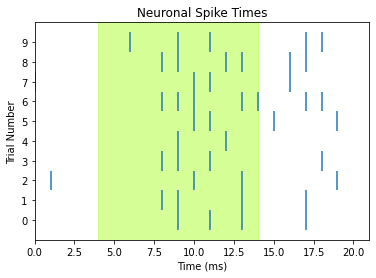

In [12]:
fig, ax = plt.subplots()

# Loop to plot raster for each trial
for trial in range(len(ten_spike_trains)):
    spike_times = [i for i, x in enumerate(ten_spike_trains[trial]) if x == spike_value]
    ax.vlines(spike_times, trial - 0.5, trial + 0.5)

ax.set_xlim([0, len(spike_train)])
ax.set_xlabel('Time (ms)')

# specify tick marks and label label y axis
ax.set_yticks(range(len(ten_spike_trains)))
ax.set_ylabel('Trial Number')

ax.set_title('Neuronal Spike Times') 

# add shading for stimulus duration)
ax.axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

plt.show()

---
## Convert to NumPy array

Recall that `ten_spike_trains` is a list of lists — one list for each trial. Another way of thinking of this data is as a **2 dimensional (2D) array**. An array is a data structure composed of sequences of values. A Python list is an example of a 1 dimensional (1D) array. So for example, our first `spike_train` was a 1D array composed of a series of 21 values. 

~~~python
spike_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
~~~

A 2D array is basically a matrix with rows and columns. pandas DataFrames are one example of a 2D array. The number of values (cells) in a 2D array is the number of rows times the number of columns. In other words, all the rows, and columns, of an array must be the same length.

For example, in our `ten_spike_trains` data set, we have the same number of values for each spike train (21), so we can imagine our data as an array where rows are trials, and columns are time points. 

<div class="alert alert-block alert-info">
    
Unlike pandas DataFrames, arrays can have more than 2 dimensions. You can think of a 3D array as a 3D cube with the third dimension being depth. For now, we'll stick with 2D arrays though!
    </div>


Python's NumPy package provides a `numpy.ndarray` (where `nd` stands for *n*-dimensional, meaning any number of dimensions) data structure and a wide variety of vectorized (optimized) functions and methods for working with arrays. If we give it our `ten_spike_trains` list of lists, it converts it to a NumPy array: 

In [13]:
spike_array = np.array(ten_spike_trains)
print(spike_array)
type(spike_array)

[[0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0]]


numpy.ndarray

The result looks very much like the original list of lists, except that there are no commas between the list items. As well, the output of the last command shows us that this is an object of type `numpy.ndarray`.

The square brackets of NumPy arrays represent the dimensions of the data. So, rows are the first dimension, and each row is in its own set of square brackets. All of the rows are contained in one set of square brackets representing the second dimension — i.e., that all of the rows together form a set of columns.

### Why NumPy arrays?

Since the NumPy array version of our data looks pretty much the same as the list of lists format, you may wonder why we introduce a new data type rather than continuing to work with lists. There are a few reasons:
1. NumPy is faster
    - The NumPy package is optimized specifically for working with array-format data, including manipulating the data, selecting subsets, and performing mathematical operations. Lists are deisgned for more general purposes and so run more slowly with arrays. So working with NumPy arrays is much faster than lists, and the performance benefits increase as data sets get larger. 
1. NumPy has many tools
    - Since NumPy is designed for working with arrays, it has a large number of functions and methods that allow you to do a lot of common data science tasks very easily.
1. NumPy is extensible
    - NumPy can handle data with more than 2 dimensions, making it powerful for complex data sets.

---
## The Peri-Stimulus Time Histogram (PSTH)

Along with raster plots, another common way of visualizing spike train data is the *peri-stimulus time histogram* (PSTH). As the name implies, this is a histogram — a plot of the count of spikes at each time point in the spike trains. PSTHs are a useful tool in aggregating the data across trials. As biological entities, neurons are complex and do not always spike at exactly the same time, or rate, every time they are stimulated. This is why we collect data over many trials — to identify the average pattern of responding. By summing the number of spikes in short time bins, PSTHs allow us to visualize when the neuron is most likely to spike.

Much of the code below is the same as for the previous raster plot. However, in place of drawing the vertical lines, we run `plt.bar()` to generate a bar plot. There will be one bar for each time point, and its height will represent the number of spikes at that time point, over the 10 trials. The required arguments for `plt.bar()` are `x` and `height`.

For `x`, we want the data time points (0–20 ms), which we can get from the number of columns in the array. NumPy arrays have a `.shape` property which returns the shape of the 2D array as `[rows, columns]`. So `spike_array[1]` will return the number of columns (`spike_array[0]` would give the number of rows). We pass this length to `range()` to generate the range of values for the *x* axis.

For the height of the bars we pass the sum across rows of the NumPy array: `np.sum(spike_array, 0)`. The second argument, `0`, is the dimension of the array we want to sum over. Recall that the first dimension of the array is the rows, and that Python indexes from 0. So `0` tells NumPy to sum over the rows dimension (and `1` would be used if we wanted to sum over columns instead).

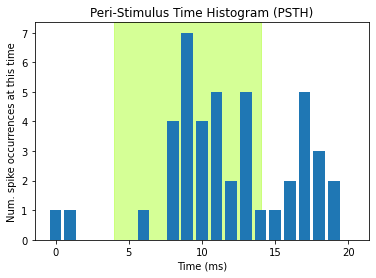

In [14]:
fig, ax = plt.subplots()

# add shading for stimulus duration)
# Do this first, so it's drawn "under" the PSTH
ax.axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

# Draw the PSTH
ax.bar(range(spike_array.shape[1]), 
        np.sum(spike_array, 0)
       )

# Make pretty
ax.set_title('Peri-Stimulus Time Histogram (PSTH)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Num. spike occurrences at this time')

plt.show()

The PSTH allows us to easily visualize the apparent relationship between light stimulation and spiking: relative to the baseline period prior to stimulation, the neuron shows a noticeable increase in spike probability starting approximately 2.5 ms after light onset, peaking around 4 ms post-onset, and then decreasing as the light stays on. Interestingly, there appears to be another increase in spike probability after the light is turned off again. Some cells show *offset responses* like this, as well as onset responses.

Viewing the data as a PSTH reveals structure (relationships — in this case between stimulation and spike probability) much more easily than look at an array of numbers. This is even more true in real data sets, that involve arrays a lot bigger than the one we're working with!

## Normalizing PSTHs
The above PSTH simply plots the number of spikes per time bin (using the `np.sum()` function). Thus the numbers plotted are somewhat arbitrary, in that they will differ depending on the number of trials that were run. As well, even when we see peaks in the histogram, if we visualize the raw count without knowing the number of trials that contributed, we don't have a good way of interpreting the data. That is, since we know here that we have 10 trials, a count of 7 is a high proportion of trials. However, if the data comprised 50 trials, a peak of 7 might not be compelling evidence that the neuron was responsive to the stimulus. We should always strive for transparency and readability in visualizing data, and minimize the need for the viewer to read additional material (e.g., the methods section where hopefully the number of trials is reported) to interpret the plot. As well, plotting things in standardized units makes it easier to compare across plots, articles, etc.. This is the process of **normalization** that we discussed previously in the context of [Seaborn](../visualization/seaborn.html#examining-distributions-with-histograms) histograms.

In the case of PSTHs, what we really want to know is how *probable* is it that the neuron will fire at a particular time point after a stimulus, across trials. We can do this by computing the mean number of spikes at each time point with `np.mean()`, rather than `np.sum()`. Since the only possible values are 0 or 1, the mean will represent the proportion of times that the neuron spiked at that time point, regardless of how many trials comprised the data.

Normalizing the height of the bars can further facilitate interpretation of the data, because now we have an interpretable scale for the data. We might want to get a sense of whether the probability of firing is greater than chance, and thus likely related to the stimulus. Since, like a coin toss, the neuron only has two possible states (firing or not), a simple criterion would be to say that if the neuron fires on more than 50% of trials, it is responding to the stimulus. We can facilitate this interpretation for our viewer by adding a horizontal dashed line at 0.5 on the *y* axis, using `plt.axhline()`

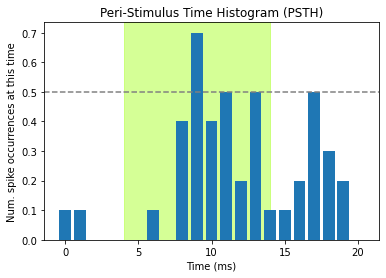

In [15]:
fig, ax = plt.subplots()

# add shading for stimulus duration)
ax.axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

# Draw the PSTH
ax.bar(range(spike_array.shape[1]), 
        np.mean(spike_array, 0)
       )

# Add line showing chance probability of firing
ax.axhline(y=0.5, xmin=0, xmax=20, linestyle='--', color='gray')

# Make pretty
ax.set_title('Peri-Stimulus Time Histogram (PSTH)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Num. spike occurrences at this time')

plt.show()

---
## Raster + PSTH = Sub-plots

Recall our previous lesson on [sub-plots](../visualization/subplots.html). We can combine a raster plot and PSTH as two sub-plots of one figure, organized as one column and two rows:

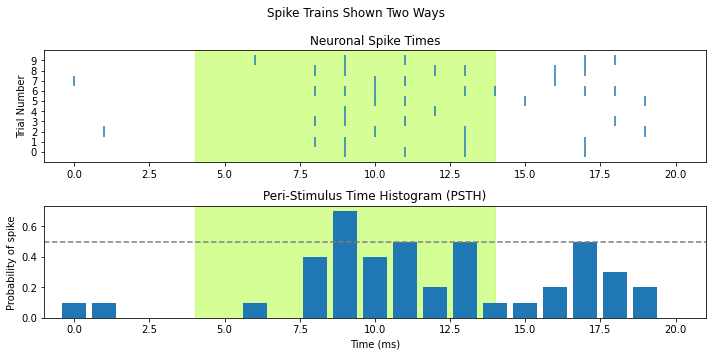

In [16]:
fig, axs = plt.subplots(2, 1, figsize=[10,5])

########################################
# draw raster into first subplot, axs[0]
# add shading for stimulus duration)
axs[0].axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

for trial in range(len(ten_spike_trains)):
    spike_times = [i for i, x in enumerate(ten_spike_trains[trial]) if x == spike_value]
    axs[0].vlines(spike_times, trial - 0.5, trial + 0.5)

# Set x axis range so that time zero is more visible    
axs[0].set_xlim([-1, len(spike_train)])

# specify tick marks and label label y axis
axs[0].set_yticks(range(len(ten_spike_trains)))
axs[0].set_ylabel('Trial Number')

axs[0].set_title('Neuronal Spike Times') 

#######################################
# draw PSTH into second subplot, axs[1]
# add shading for stimulus duration
axs[1].axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

# Draw the PSTH
axs[1].bar(range(spike_array.shape[1]), 
           np.mean(spike_array, 0)
           )

# Use same x axis limits as for raster plot
axs[1].set_xlim([-1, len(spike_train)])

# Add line showing chance probability of firing
axs[1].axhline(y=0.5, xmin=0, xmax=20, linestyle='--', color='gray')

# Make pretty
axs[1].set_title('Peri-Stimulus Time Histogram (PSTH)')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Probability of spike')


### Overall figure stuff
fig.suptitle('Spike Trains Shown Two Ways')
plt.tight_layout()
plt.show()